# Setup

In [1]:
#import tensorflow as tf
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2 as cv
import math
import os
import keras_tuner
import train
import evaluate

# Dataset loading

Dataset is loaded from csv files contained in a directory, where pixel information of the images (0-255) is stored together with labels.
This loading is performed using a Trainer object, which also contains visualization methods, and performs the resizing and normalization of images.

Parameter for Trainer should be explicitely called, since it accepts several data source (pict = image array, data = image + labels array
or datapath = directory containing annotated csv files)

The Trainer default label-picture split is performed for image size of 76*82 in the dataset.
It also removes any picture labelled with a 0 (errors).

## Loading and splitting of dataset

(5131, 6233)


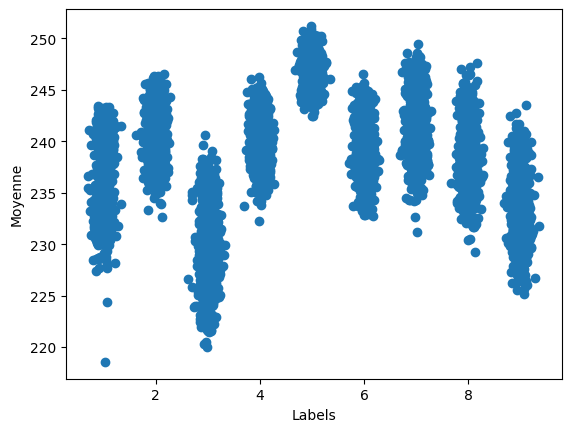

(5131, 76, 82)
(5131,)


In [2]:
train_data = train.Trainer(datapath = "data_resultsheets/Train/")
print(train_data.full_da.shape)
train_data.plot_mpi()
print(train_data.pict.shape)
print(train_data.label.shape)

(764, 6233)


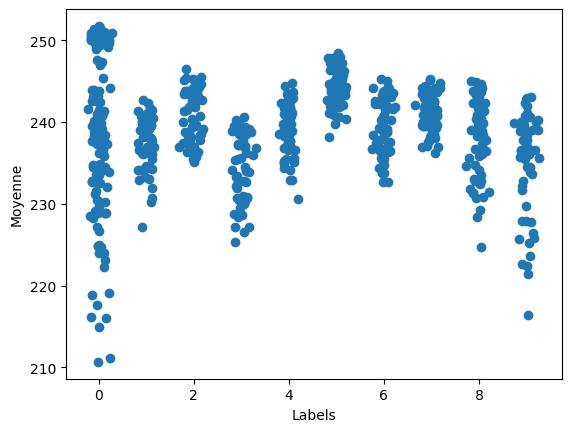

(764, 76, 82)
(559,)


In [3]:
test_data = train.Trainer(datapath = "data_resultsheets/Test/")
print(test_data.full_da.shape)
test_data.plot_mpi()
print(test_data.pict.shape)
print(test_data.label.shape)

In [39]:
test_pict = test_data.pict
test_labs = test_data.label_zeros

zeros_i = np.where(test_labs == 0)[0]
five_i = np.where(test_labs == 5)[0]
nine_i = np.where(test_labs == 9)[0]

In [41]:
print(test_pict[zeros_i].shape)
print(test_pict[five_i].shape)
print(test_pict[nine_i].shape)
zeros = test_pict[zeros_i].reshape((205, -1))
fives = test_pict[five_i].reshape((82, -1))
nines = test_pict[nine_i].reshape((57, -1))

(205, 76, 82)
(82, 76, 82)
(57, 76, 82)


In [42]:
print(np.mean(zeros))
print(np.mean(fives))
print(np.mean(nines))

242.67145
244.57646
235.02847


In [ ]:
# Plot max instead of mean pixel intensity
# Label/visualize among zeros which are empty

## Picture resizing and normalization


Default resizing is to (28, 28) but one can call redimension_pict method of the object to perform resizing with another size,
this will update the pict_redim attribute.

Normalization is done by dividing by 255 (max pixel value). Resized and normalized pictures are stored in pict_redim attribute.

In [4]:
print(test_data.pict_redim.shape)
print(train_data.pict_redim.shape)
print(f'Pixel range : {train_data.pict_redim.min()} to {train_data.pict_redim.max()}')

(559, 28, 28)
(5131, 28, 28)
Pixel range : 0.0 to 1.0


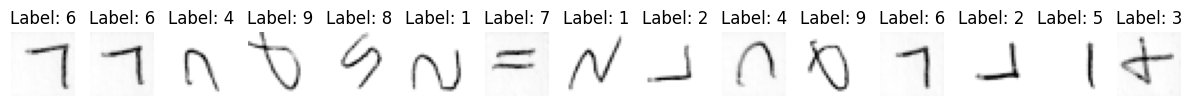

In [5]:
train_data.visualize_random_samples(y = train_data.label, num_samples = 15)

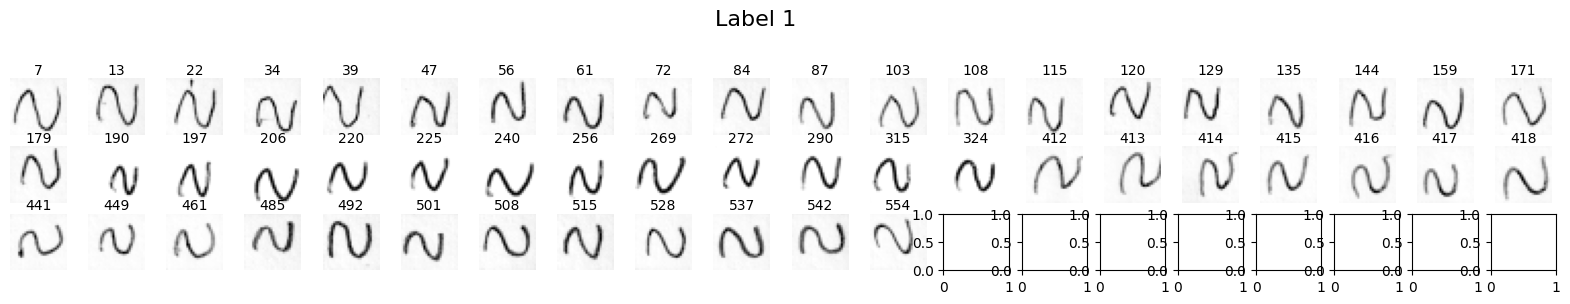

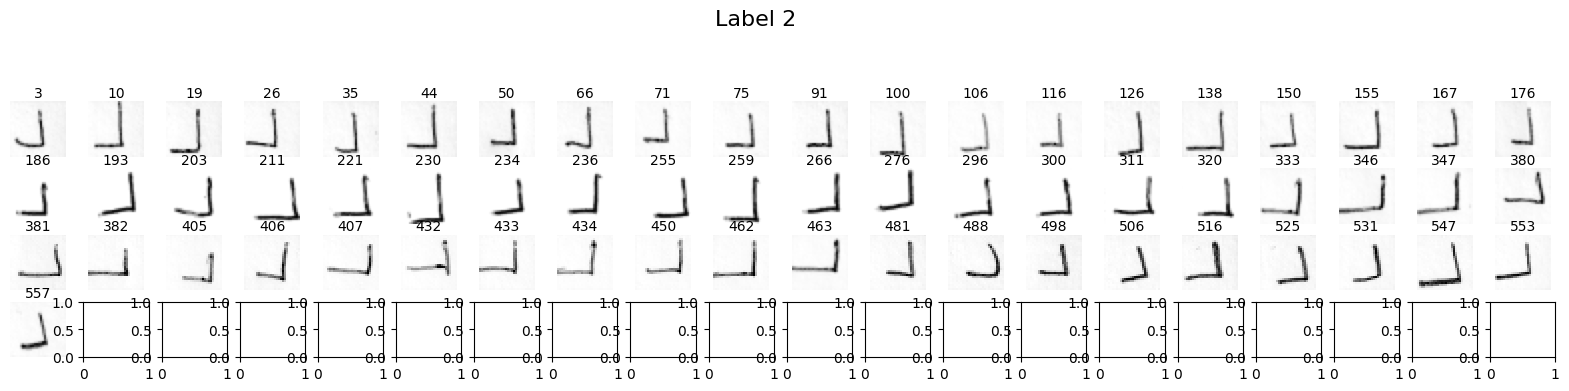

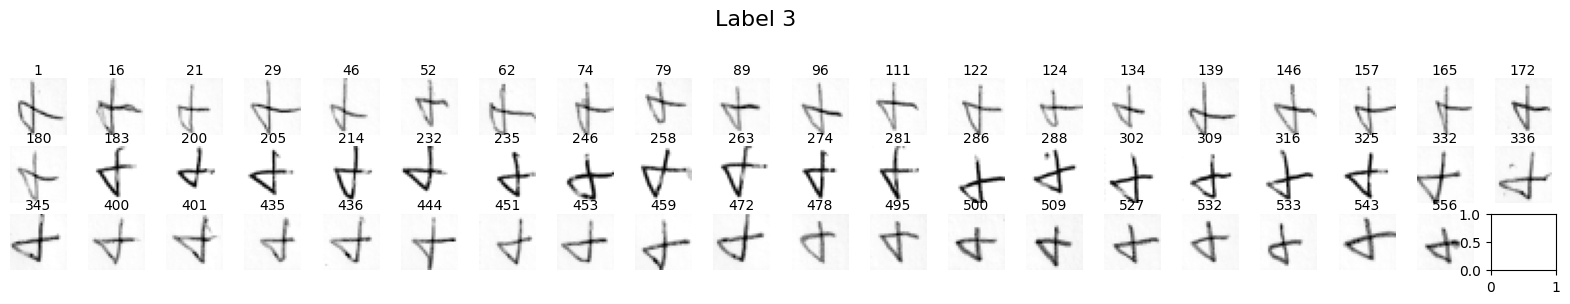

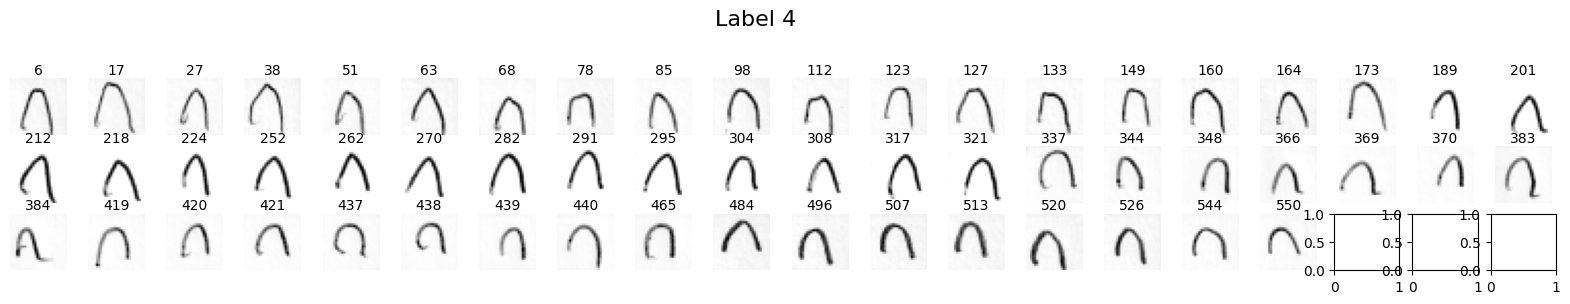

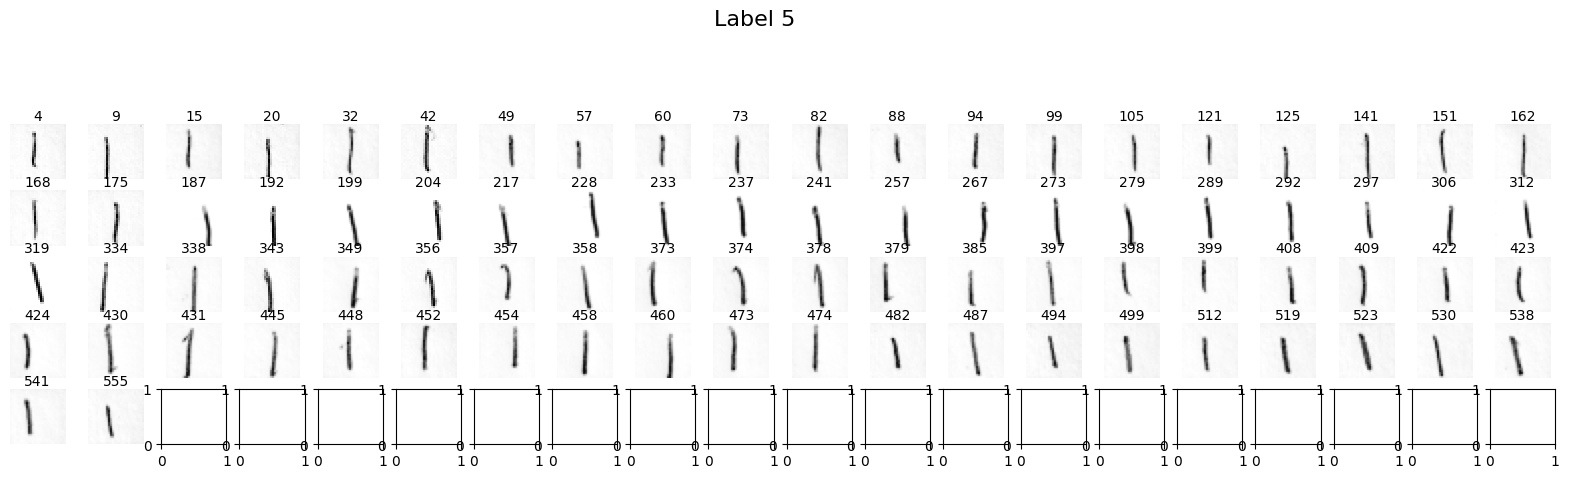

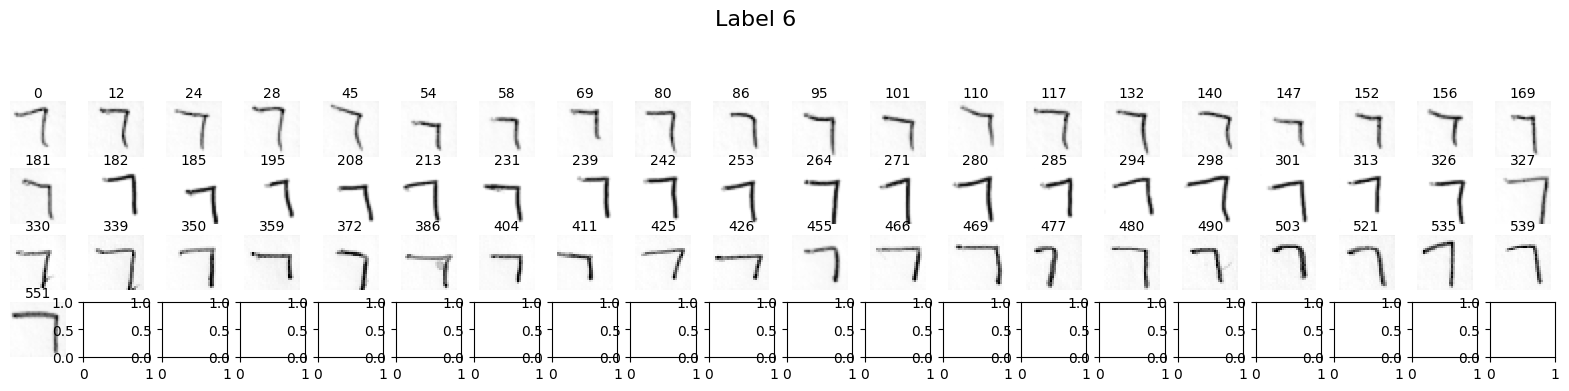

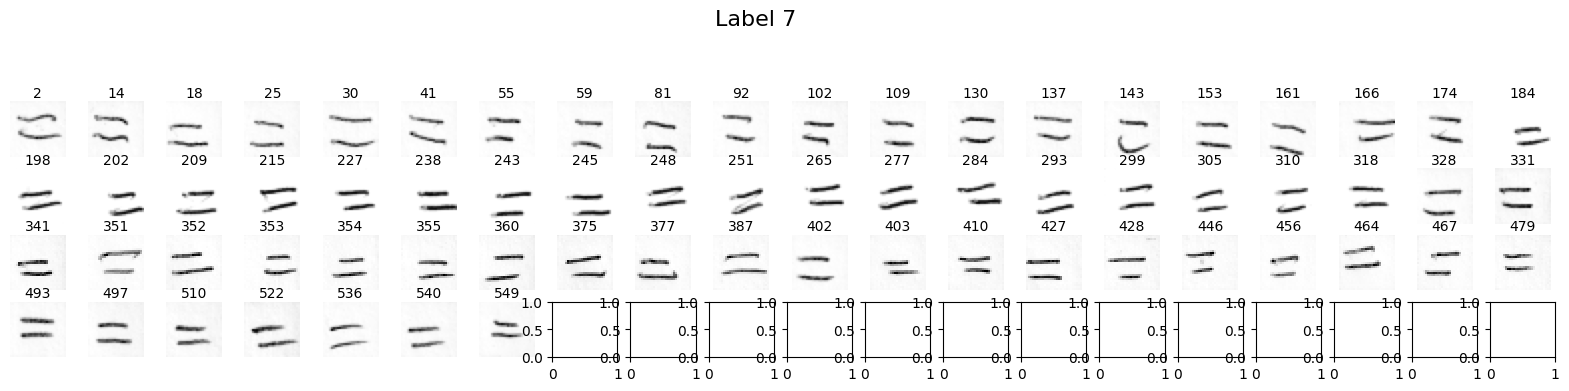

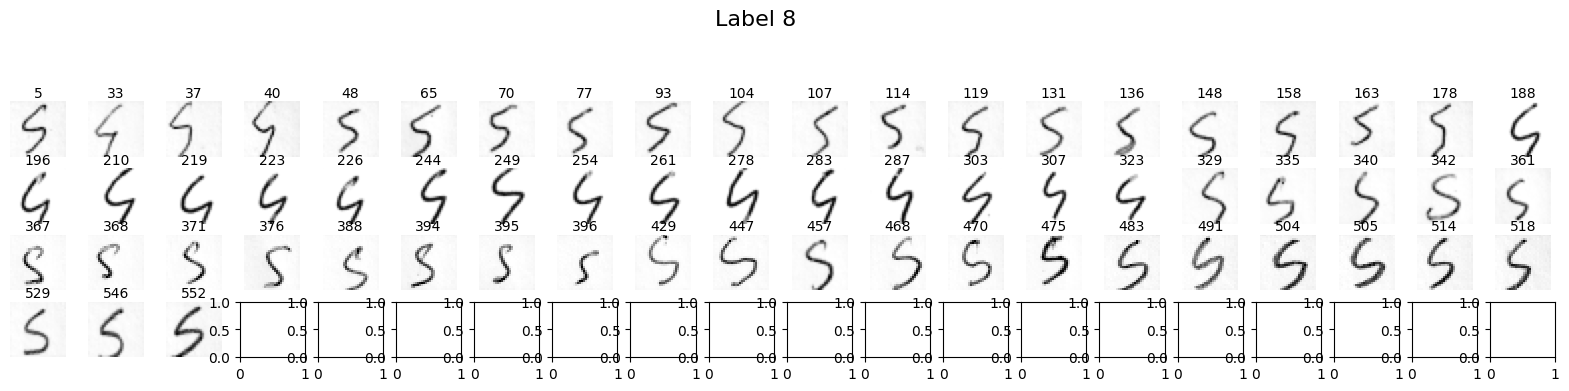

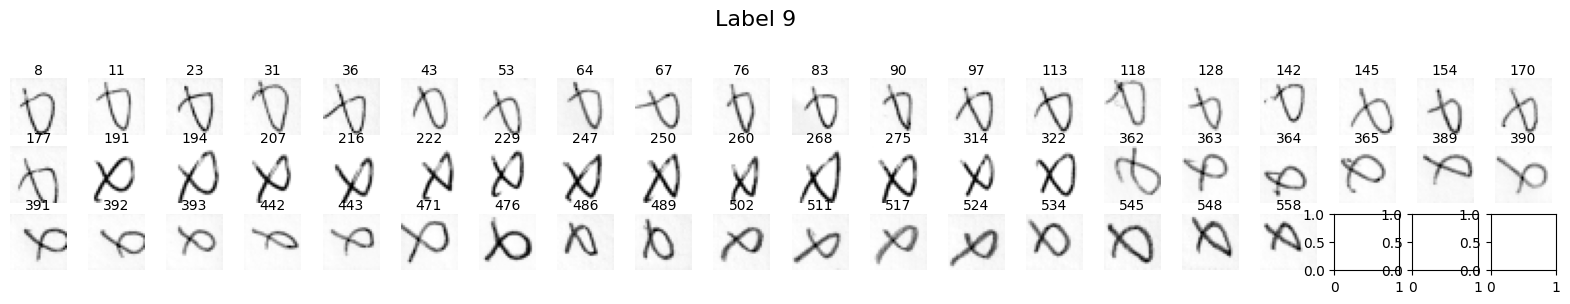

In [7]:
test_data.visualize_symbols(labels = test_data.label, imgperrow = 20)

## Train-test split

Here we use all data from train folder at training dataset, and all data from test folder as test dataset.
This can be adapted by pooling all the data and then redividing in train and test for example.

In [6]:
X_train = train_data.pict_redim
X_val = test_data.pict_redim
y_train = train_data.label
y_val = test_data.label
X_test = test_data.pict_zeros
y_test = test_data.label_zeros

Training DataArray :
(5131, 28, 28)
(5131,)
Test DataArray :
(764, 28, 28)
(764,)


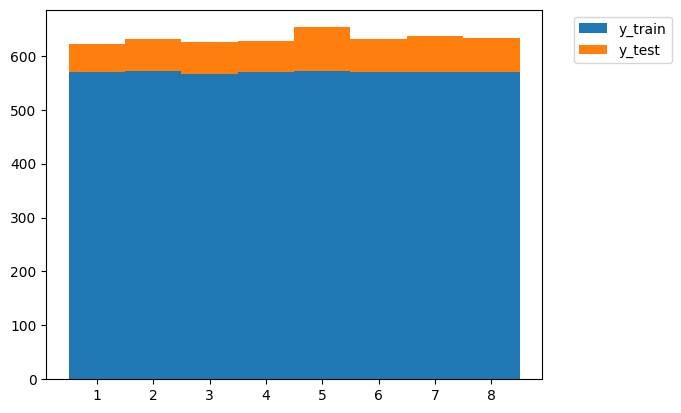

In [7]:
print("Training DataArray :")
print(X_train.shape)
print(y_train.shape)

print("Test DataArray :")
print(X_test.shape)
print(y_test.shape)
plt.hist([y_train.flatten(), y_test.flatten()], bins=np.arange(0.5, 9.5, 1), stacked=True, label=['y_train', 'y_test'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Training of the model

## Dense Neural Network

### Hyperparameters tuning

We define a function with range of parameters to optimize, and a function to get the model with given parameters.

In [8]:
def build_model_dnn(hp):
    shape = (28,28)
    hidden1=hp.Int("units_d1", min_value=32, max_value=512, step=32)
    hidden2=hp.Int("units_d2", min_value=32, max_value=512, step=32)

    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    model = get_model_dnn(shape, hidden1, hidden2, lr)
    
    return model



In [9]:
def get_model_dnn(shape, hidden1, hidden2, lr):
    model = keras.models.Sequential([
        keras.layers.Input(shape, name='InputLayer'),
        keras.layers.Flatten(),
        keras.layers.Dense(hidden1, activation='relu', name='Dense_n1'),
        keras.layers.Dense(hidden2, activation='relu', name='Dense_n2'),
        keras.layers.Dense(9, activation= 'softmax', name='Output')])
    
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate = lr),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
    ],)
    return model

In [10]:
build_model_dnn(keras_tuner.HyperParameters())

<Sequential name=sequential, built=True>

In [11]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model_dnn,
    objective="val_acc",
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory="models/dnn_tuning",
    project_name="trec_dnn",
)
tuner.search_space_summary()

Search space summary
Default search space size: 3
units_d1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_d2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [55]:
tuner.search(X_train, y_train-1, epochs=5, validation_data=(X_val, y_val-1))


Trial 50 Complete [00h 00m 07s]
val_acc: 0.6270125210285187

Best val_acc So Far: 0.6815742552280426
Total elapsed time: 00h 05m 21s


In [56]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n1 (Dense)                     │ (None, 480)                 │         376,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n2 (Dense)                     │ (None, 384)                 │         184,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 9)                   │           3,465 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 564,969 (2.16 MB)

 Trainable params: 564,969 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
tuner.results_summary()

Results summary
Results in models/dnn_tuning\trec_dnn
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 43 summary
Hyperparameters:
units_d1: 480
units_d2: 384
lr: 0.001099878798632092
Score: 0.6815742552280426

Trial 09 summary
Hyperparameters:
units_d1: 288
units_d2: 480
lr: 0.00010961053875998976
Score: 0.6449016034603119

Trial 24 summary
Hyperparameters:
units_d1: 512
units_d2: 160
lr: 0.0027651012508793766
Score: 0.64400714635849

Trial 45 summary
Hyperparameters:
units_d1: 192
units_d2: 128
lr: 0.00035276138234744287
Score: 0.64400714635849

Trial 14 summary
Hyperparameters:
units_d1: 480
units_d2: 288
lr: 0.0014196495433366004
Score: 0.6431127190589905

Trial 33 summary
Hyperparameters:
units_d1: 288
units_d2: 480
lr: 0.0005380704122299075
Score: 0.6422182619571686

Trial 37 summary
Hyperparameters:
units_d1: 384
units_d2: 448
lr: 0.0017976241984637314
Score: 0.6395348906517029

Trial 15 summary
Hyperparameters:
units_d1: 224
units_d2: 64
lr: 0.0005144475

### Entrainement du modèle avec les meilleurs hyperparamètres

In [59]:
best_hps = tuner.get_best_hyperparameters(5)
modelDNN = build_model_dnn(best_hps[0])

In [12]:
shape = (28,28)
hidden1 = 480
hidden2 = 384
lr = 0.001099878798632092
modelDNN = get_model_dnn(shape, hidden1, hidden2, lr)

In [13]:
modelDNN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n1 (Dense)                     │ (None, 480)                 │         376,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n2 (Dense)                     │ (None, 384)                 │         184,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 9)                   │           3,465 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 564,969 (2.16 MB)

 Trainable params: 564,969 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
callbacksDNN = [keras.callbacks.ModelCheckpoint(filepath="models/DNN_{epoch:02d}-{val_acc:.3f}.keras", monitor = 'val_acc',
                                                      save_best_only = True, mode = 'max', initial_value_threshold = 0.7),
                      keras.callbacks.EarlyStopping(monitor = 'val_acc', mode = 'max', patience=10, start_from_epoch = 15, 
                                                   restore_best_weights = True)]

In [15]:
batch_size = 32
epochs = 100

historyDNN = modelDNN.fit(
    X_train,
    y_train-1,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val-1),
    callbacks=callbacksDNN,
)


Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.2372 - loss: 2.1696 - val_acc: 0.5063 - val_loss: 1.5019
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6639 - loss: 1.0707 - val_acc: 0.5581 - val_loss: 1.3228
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7700 - loss: 0.7373 - val_acc: 0.5277 - val_loss: 1.3547
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8198 - loss: 0.6157 - val_acc: 0.6029 - val_loss: 1.1810
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8450 - loss: 0.5210 - val_acc: 0.6118 - val_loss: 1.1666
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8009 - loss: 0.6356 - val_acc: 0.6512 - val_loss: 1.0934
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8593 - loss: 0.4571 - val_acc: 0.6512 - val_loss: 1.0729
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8949 - loss: 0.3771 - val_acc: 0.7227 - val_loss: 0.9874
Epoch 9/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

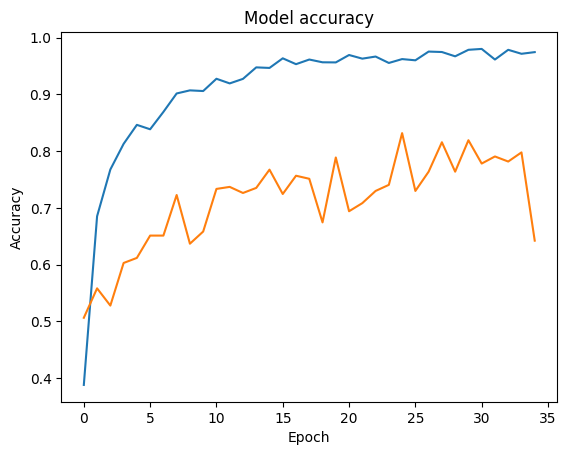

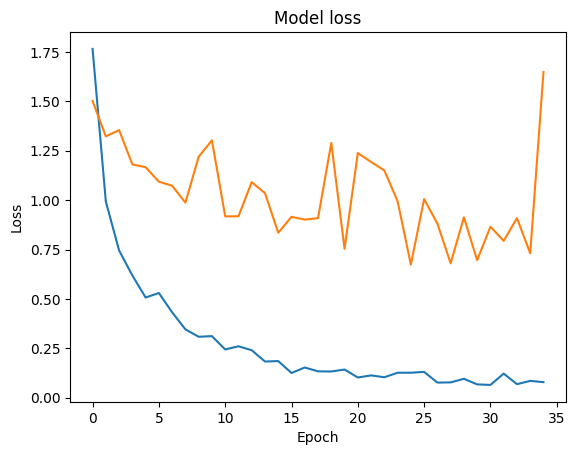

In [16]:
# Plot training & validation accuracy values
plt.plot(historyDNN.history['acc'], label = 'train')
plt.plot(historyDNN.history['val_acc'], label = 'test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot training & validation loss values
plt.plot(historyDNN.history['loss'], label = 'train')
plt.plot(historyDNN.history['val_loss'], label = 'test')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Convolutive Neural Network

In [37]:
x_train = X_train.reshape(-1, 28, 28, 1)
x_test = X_test.reshape(-1, 28, 28, 1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(x_train.min(), x_train.max())

(5131, 28, 28, 1)
(559, 28, 28, 1)
(5131,)
(559,)
0.0 1.0


In [38]:
def get_model_cnn(shape):
    conv1 = 8
    conv2 = 16
    kernel = (3,3)
    window = (2,2)
    dropout1 = 0.2
    dropout2 = 0.2
    dropout3 = 0.5
    hidden1 = 100
    
    model = keras.models.Sequential([
        keras.layers.Input(shape, name='InputLayer'),
        keras.layers.Conv2D(conv1, kernel, activation = 'relu', name='Conv_1'),
        keras.layers.MaxPooling2D(window, name='MaxPool_1'),
        keras.layers.Dropout(dropout1, name='Dropout_1'),
        keras.layers.Conv2D(conv2, kernel, activation = 'relu', name='Conv_2'),
        keras.layers.MaxPooling2D(window, name='MaxPool_2'),
        keras.layers.Dropout(dropout2, name='Dropout_2'),
        keras.layers.Flatten(),
        keras.layers.Dense(hidden1, activation='relu', name='Dense_1'),
        keras.layers.Dropout(dropout3, name='Dropout_3'),
        keras.layers.Dense(10, activation= 'softmax', name='Output')])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [39]:
size = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
modelCNN = get_model_cnn(size)
modelCNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv2D)                      │ (None, 26, 26, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_1 (MaxPooling2D)             │ (None, 13, 13, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 13, 13, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv_2 (Conv2D)                      │ (None, 11, 11, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_2 (MaxPooling2D)             │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 100)                 │          40,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,358 (165.46 KB)

 Trainable params: 42,358 (165.46 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
callbacksCNN = [keras.callbacks.ModelCheckpoint(filepath="models/CNN_{epoch:02d}-{val_accuracy:.3f}.keras", monitor = 'val_accuracy',
                                                      save_best_only = True, mode = 'max', initial_value_threshold = 0.7),
                      keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, start_from_epoch = 5, 
                                                   restore_best_weights = True)]

In [42]:
batch_size = 32
epochs = 50

historyCNN = modelCNN.fit(
    x_train,
    y_train-1,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test-1),
    callbacks=callbacksCNN,
)

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.2130 - loss: 2.0997 - val_accuracy: 0.6834 - val_loss: 1.0450
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.7924 - loss: 0.6611 - val_accuracy: 0.7996 - val_loss: 0.6908
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8722 - loss: 0.4163 - val_accuracy: 0.8390 - val_loss: 0.5782
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9184 - loss: 0.2909 - val_accuracy: 0.8408 - val_loss: 0.5786
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9354 - loss: 0.2156 - val_accuracy: 0.8587 - val_loss: 0.5020
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9475 - loss: 0.1724 - val_accuracy: 0.8891 - val_loss: 0.4053
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9582 - loss: 0.1429 - val_accuracy: 0.8748 - val_loss: 0.4269
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9626 - loss: 0.1218 - val_accu

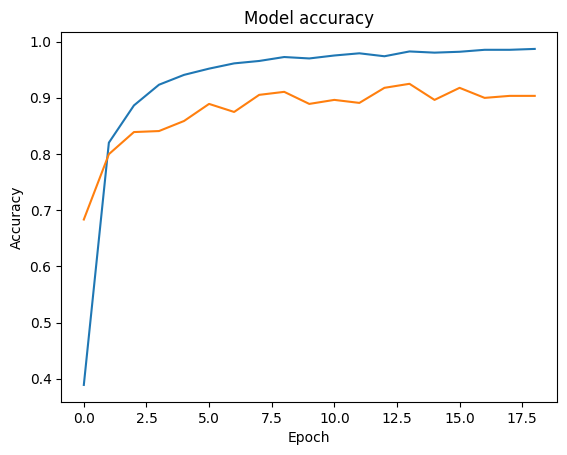

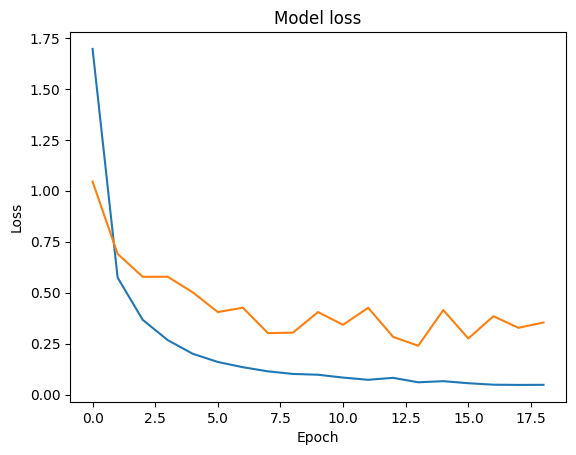

In [44]:
# Plot training & validation accuracy values
plt.plot(historyCNN.history['accuracy'], label = 'train')
plt.plot(historyCNN.history['val_accuracy'], label = 'test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot training & validation loss values
plt.plot(historyCNN.history['loss'], label = 'train')
plt.plot(historyCNN.history['val_loss'], label = 'test')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluation of model

Evaluation is done using the Evaluator object, which can be instanciated with test dataset (X_test the images and y_test the labels).
Prediction can be made with a model saved during the training phase by providing its path.
Labels are inferred from prediction probabilities using the argmax function, only when the max probability is >  0.7.
Otherwise label 0 (error) is assigned, meaning the model cannot make a reliable prediction.

The Evaluator object can then perform correction method, called by specifying correct labels and test labels to compare them to.
Labels are stored in Evaluator in the label attribute which is a dictionnary. In the correction method, confusion matrix and accuracy are calculated
using scikit learn API.

Following method metrics_calculation can be called to calculate custom metrics. We calculate these metrics to have a per label view of false positives and false negatives. This is important since in our model, we want to minimize false positive more importantly than minimizing false negative.
* False positives = symbols labelled correct while they are:
  * an error : FP_error
  * or a different symbol : FP_symbol
* False negative = symbols which are correct but are labelled as:
  * an error : FN_error
  * or a different symbol: FN_symbol

To evaluate the model, we use the test with the errors (0).

## Dense Neural Network

In [17]:
evaDNN = evaluate.Evaluator(X_test, y_test)
print(evaDNN.X.shape)
print(evaDNN.labels['train_labels'].shape)

(764, 28, 28)
(764,)


In [18]:
evaDNN.predict(modelpath = "models/DNN_26-0.848_20240602.keras")
print(evaDNN.labels['predicted_labels'].shape)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(764,)


In [19]:
evaDNN.correction(correct_labels = evaDNN.labels['train_labels'], test_labels = evaDNN.labels['predicted_labels'])
evaDNN.metrics_calculation()


metrics calculation


Accuracy : 0.5706806282722513, errors : 0.4293193717277487


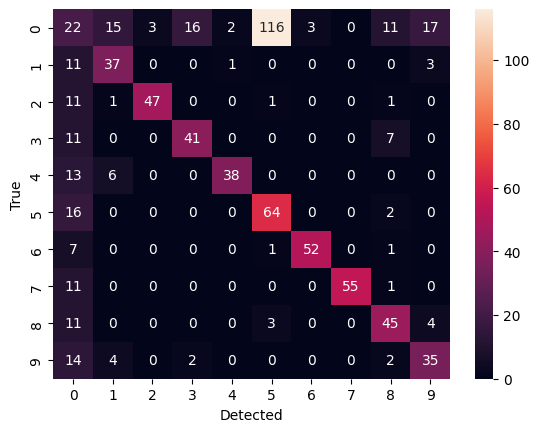

In [20]:
evaDNN.cm_plot()
print(f'Accuracy : {evaDNN.g_accuracy}, errors : {evaDNN.g_error}')

,0,1,2,3,4,5,6,7,8,9
Precision,0.173228,0.587302,0.940000,0.694915,0.926829,0.345946,0.945455,1.000000,0.642857,0.593220
Recall,0.107317,0.711538,0.770492,0.694915,0.666667,0.780488,0.852459,0.820896,0.714286,0.614035


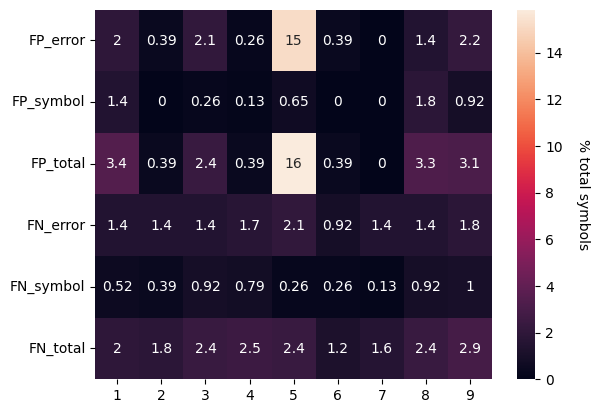

In [21]:
evaDNN.metrics_plot()
evaDNN.metrics_df()

## Convolutive Neural Network

In [45]:
evaCNN = evaluate.Evaluator(x_test, y_test)
print(evaCNN.X.shape)
print(evaCNN.labels['train_labels'].shape)
evaCNN.predict(modelpath = "models/CNN_14-0.925.keras")
print(evaCNN.labels['predicted_labels'].shape)

(559, 28, 28, 1)
(559,)
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
(559,)


In [46]:
evaCNN.correction(correct_labels = evaCNN.labels['train_labels'], test_labels = evaCNN.labels['predicted_labels'])
evaCNN.metrics_calculation()

metrics calculation


D:\WORKER\Documents\Stage\trec-coding\evaluate.py:46: RuntimeWarning: invalid value encountered in scalar divide
  FP_error = np.array([self.cm[0, i] for i in range(1, 10)])


Accuracy : 0.8819320214669052, errors : 0.11806797853309481


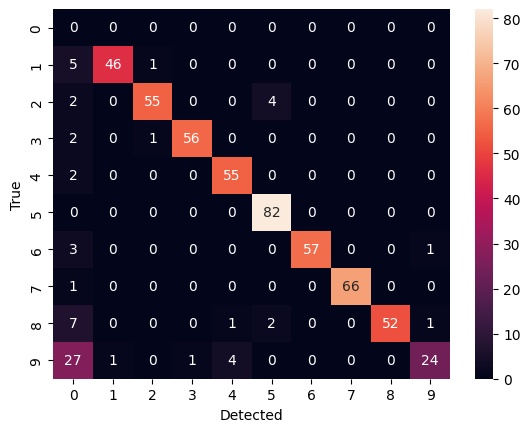

In [47]:
evaCNN.cm_plot()
print(f'Accuracy : {evaCNN.g_accuracy}, errors : {evaCNN.g_error}')

,0,1,2,3,4,5,6,7,8,9
Accuracy,0.0,0.978723,0.964912,0.982456,0.916667,0.931818,1.000000,1.000000,1.000000,0.923077
Recall,NaN,0.884615,0.901639,0.949153,0.964912,1.000000,0.934426,0.985075,0.825397,0.421053


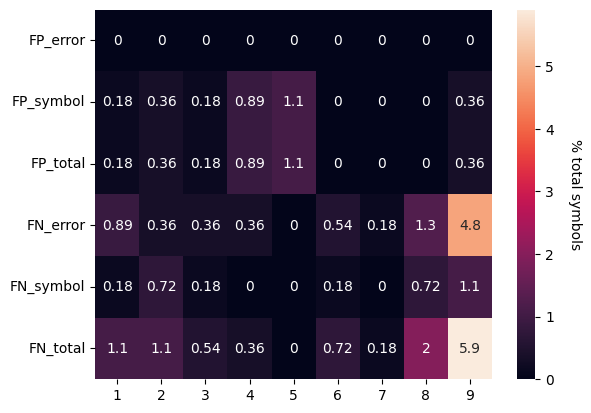

In [48]:
evaCNN.metrics_plot()
evaCNN.metrics_df()